In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data  import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data  import parent_labeler, listify
from sentimentanalyser.data.text   import TextList, ItemList, SplitData
from sentimentanalyser.utils.files import pickle_dump, pickle_load

from sentimentanalyser.preprocessing.processor import TokenizerProcessor, NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [3]:
from functools import partial

In [4]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [5]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [6]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [7]:
imdb_data = ll_imdb.clas_databunchify(64)

In [8]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import LR_Find, CudaCallback, GradientClipping
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamScheduler
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import Recorder
from sentimentanalyser.training.trainer import Trainer

In [9]:
from sentimentanalyser.utils.dev import print_dims
from sentimentanalyser.utils.training import get_embedding_vectors
from sentimentanalyser.utils.metrics import accuracy
from tqdm.auto import tqdm

In [10]:
from sentimentanalyser.models.rnn import AttnAWDModel
from sentimentanalyser.models.regularization import WeightDropout
from sentimentanalyser.data.core import ListContainer

In [11]:
import torch
import torchtext
from torch import nn
from torchtext import vocab
import matplotlib.pyplot as plt

In [12]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [13]:
glove_eng = vocab.GloVe(cache=path_cache)

In [14]:
local_vocab = proc_num.vocab

## Hooks

In [15]:
class Hook():
    def __init__(self, m, f, forward=True):
        if isinstance(m, nn.Module):
            if forward:
                self.hook = m.register_forward_hook(partial(f, self))
            else:
                self.hook = m.register_forward_hook(partial(f, self))
        elif isinstance(m, torch.Tensor):
            self.hook = m.register_hook(partial(f, self))
    
    def remove(self):
        self.hook.remove()
    
    def __del__(self):
        self.remove()

In [16]:
class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        return
    
    def __del__(self):
        self.remove()
        return
    
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        return
    
    def remove(self):
        for h in self:
            h.remove()

## Hooks on Modules 
We use these to display activations from a particular layer.

In [17]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[])
    if not hasattr(hook, 'layer_name'):
        hook.layer_name = mod.__class__.__name__
    means, stds = hook.stats
    if mod.training:
        if isinstance(mod, WeightDropout):
            means.append(outp[0].data.mean().item())
            stds.append(outp[0].data.std().item())
        else:
            means.append(outp.data.mean().item())
            stds.append(outp.data.std().item())

### Training

In [18]:
def get_basic(Model, num_layers=2):
    model = Model(proc_num.vocab, glove_eng,num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    return model, loss_func, opt

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-4, 1e-3), sched_cos(1e-3, 3e-5)])

In [20]:
cbfs = [partial(AvgStatsCallback, [accuracy]),
        partial(ParamScheduler,'lr', [sched]),
        partial(GradientClipping, clip=0.1),
        ProgressCallback,
        CudaCallback,
        Recorder
       ]

In [21]:
model, loss_func, opt = get_basic(AttnAWDModel)

In [22]:
trainer = Trainer(imdb_data, model, loss_func, opt,
                  cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.431661,0.788480,0.319430,0.859200,01:38
1,0.228481,0.911160,0.216706,0.916320,01:38


/home/anukoolpurohit/anaconda3/envs/Torch10cuda/lib/python3.7/site-packages/torch/nn/utils/clip_grad.py:24: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  parameters = list(filter(lambda p: p.grad is not None, parameters))


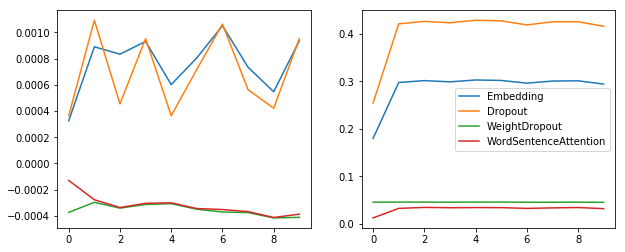

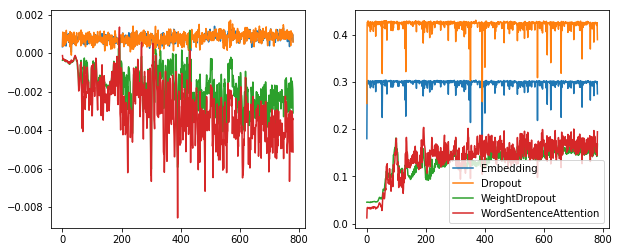

In [23]:
with Hooks(list(model.children())[:4], append_stats) as hooks:
    trainer.fit(2)
    names = []
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        names.append(h.layer_name)
        ms, ss = h.stats
        ax0.plot(ms[:10])
        #ax0.title('mean first 10')
        ax1.plot(ss[:10])
        #ax1.title('std first 10')
    plt.legend(names);
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        #ax0.title('mean')
        ax1.plot(ss)
        #ax1.title('std')
    plt.legend(names);

In [24]:
def append_stats1(hook, mod, inp, outp):
    if not hasattr(hook, 'hists'):
        hook.hists = []
    if not hasattr(hook, 'layer_name'):
        hook.layer_name = mod.__class__.__name__
    hists = hook.hists
    if mod.training:
        if isinstance(mod, WeightDropout):
            hists.append(outp[0].data.detach().cpu().histc(100,0,10))  # histc isn't implemented on the GPU
        else:
            hists.append(outp.data.detach().cpu().histc(100,0,10))  # histc isn't implemented on the GPU

In [25]:
model, loss_func, opt = get_basic(AttnAWDModel)

In [26]:
trainer = Trainer(imdb_data, model, loss_func, opt,
                  cb_funcs=cbfs)

In [27]:
with Hooks(list(model.children())[:4], append_stats1) as hooks:
    trainer.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.395474,0.813200,0.243230,0.902840,02:27


In [28]:
def get_hist(h): return torch.stack(h.hists).t().float().log1p()

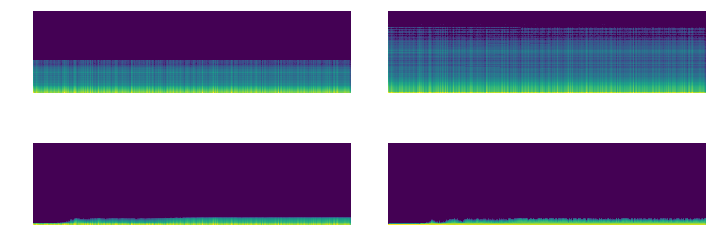

In [29]:
fig, axes = plt.subplots(2,2, figsize=(10,4))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

## Hooks on Tensors
We use these to display the gradients of each layer

In [79]:
def append_stats2(hook, x):
    if not hasattr(hook, 'hists'):
        hook.hists = []
    hists = hook.hists
    hists.append(x.cpu().histc(100,0,0.01))  # histc isn't implemented on the GPU

In [80]:
model, loss_func, opt = get_basic(AttnAWDModel)

In [81]:
trainer = Trainer(imdb_data, model, loss_func, opt,
                  cb_funcs=cbfs)

In [82]:
with Hooks(model.parameters(), append_stats2) as hooks:
    trainer.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.387313,0.822800,0.245087,0.902200,02:14


In [83]:
hooks = [hook for hook in hooks if hasattr(hook, 'hists')]

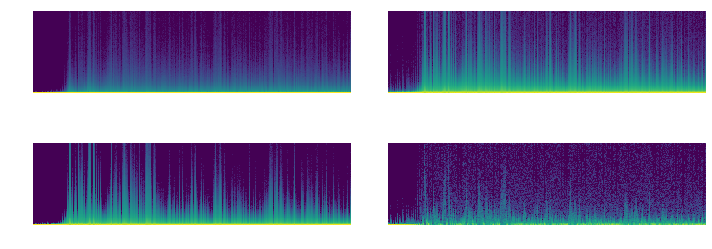

In [84]:
fig, axes = plt.subplots(2,2, figsize=(10,4))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()